In [1]:
from dolfinx import geometry
from petsc4py import PETSc
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.mesh import create_unit_square,create_rectangle, CellType, meshtags, locate_entities_boundary
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, grad, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional)

import gmsh
from dolfinx.io import VTXWriter, gmshio
import numpy as np
from mpi4py import MPI

from dx_utils import (create_obst, gather_and_sort, get_pop_cells, write_x_parview, store_array, init_db,
                    write_values_to_json, mfl_press, get_unsorted_arrays,get_pop_cells, pops_cells)

import matplotlib.pyplot as plt

[sick:78733] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.sick.1000/jf.0/510459904/shared_mem_cuda_pool.sick could be created.
[sick:78733] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [33]:
def zetta(p0, pl, pg, L=2,T=60, x=np.linspace(0,2,100)):
    """
    Calculate the zetta value for a given location in a membrane canal.

    This function computes the zetta value based on the pressures at different points
    of a membrane and the location within the canal.

    Parameters:
    -----------
    T : float
        The stiffness of the membrane
    p0 : float
        The pressure at the beginning of the membrane.
    pl : float
        The pressure at the end of the membrane.
    pg : float
        The outer pressure of the membrane.
    L : float
        The length of the membrane.
    x : float
        The location in the canal for which to calculate zetta.

    Returns:
    --------
    float
        The calculated zetta value at the given location.

    Notes:
    ------
    The function uses the following formula:
    zetta = 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L* x)
    where pd = p0 - pl

    The constant T is not defined in the function and should be provided or defined elsewhere.

    Example:
    --------
    >>> zetta(100, 80, 120, 10, 5)
    # Returns the zetta value at the midpoint of a 10-unit long membrane
    """
    assert (p0<pg)
    pd = p0-pl
    return 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L * x )

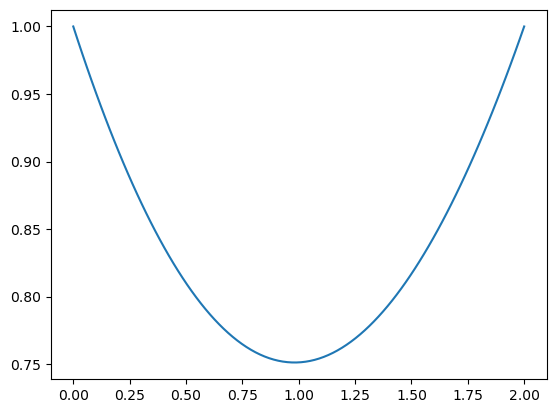

[58.3836426] [39.99976128]


In [30]:
#zetta(T, p0, pl, pg, L, x):
x = np.linspace(0,2,100)
memb = zetta(p_old2[-1], p_old2[1], 100)
memb += 1
plt.plot(x,memb)

plt.show()
x[-1]
print(p_old[-1],p_old[0])

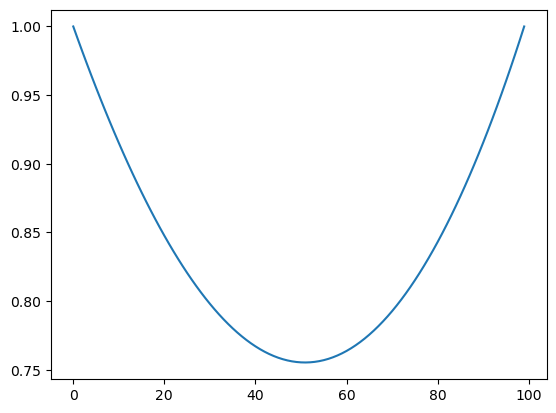

In [50]:
memb = zetta(p_old2[3], p_old2[-1], 100)
memb += 1
plt.plot(memb)

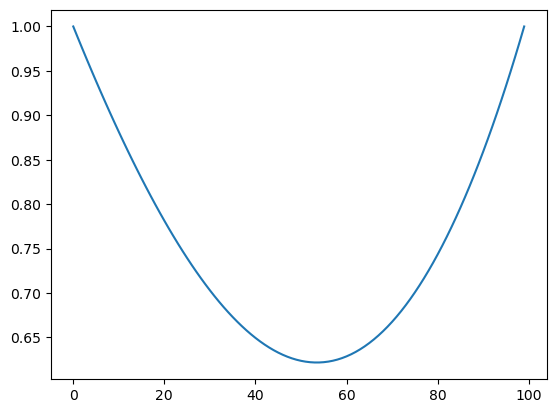

In [61]:
memb = zetta(p_old4[0], p_old4[-1], 100)
memb += 1
plt.plot(memb)

In [10]:
#zetta(T, p0, pl, pg, L, x):
x = np.linspace(0,2,100)
memb = zetta(p_old2[-1], p_old2[1], 100)
memb += 1
plt.plot(x,memb)

plt.show()
x[-1]


NameError: name 'p_old2' is not defined

In [34]:
"""def zetta(p0, pl, pg, L,T=3, x=np.linspace(0,2,100)):
    pd = p0-pl
    return 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L * x )"""
def update_membrane_mesh(comm,H, L, lc=.03, p0=0, pl=0, pg=0, first=False):
    #comm,H=1, L=3,r=.3, Ox=1.5, lc=.07
    def define_membrane(factory, begin, end, l1, lc1,L):
        memb = zetta(p0, pl, pg)
        memb += 1
        startpoint = (L/2)-(L/10)
        endpoint = (L/2)+(L/10)
        x = np.linspace(startpoint, endpoint, 100)
        lines = []
        points = []
        points.append(begin)
        for i in range(len(x)-2):
            new_point = factory.addPoint(x[i+1], memb[i+1], 0, lc1)
            points.append(new_point)
            lines.append(factory.addLine(points[-2], points[-1]))
        lines.append(factory.addLine(points[-1],end))
        return lines, points
    
    silent = False
    model_rank = 0
    infl, outfl, upper, lower = [],[],[],[]
    gmsh.initialize()
    if silent:
        gmsh.option.setNumber("General.Terminal",0)
    gmsh.model.add("canal")
    #gmsh.option.setNumber("Geometry.Tolerance", 1e-8)
    #gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", 1)
    
    cm = 1 # e-02 # not needed for our sim
    h1 = H * cm if H is not None else 1
    l1 = L * cm if L is not None else 10
    Lc1 = lc
    
    # We start by defining some points and some lines. To make the code shorter we
    # can redefine a namespace:
    factory = gmsh.model.occ
    model = gmsh.model
    if comm.rank==0:
        lowerleft = factory.addPoint(0, 0, 0, Lc1)
        lowerright = factory.addPoint(l1, 0, 0, Lc1)
        upperright = factory.addPoint(l1, h1 , 0, Lc1)
        upperleft = factory.addPoint(0, h1, 0, Lc1)
        
        begin = factory.addPoint(L/2-L/10, h1, 0, Lc1)
        end = factory.addPoint(L/2+L/10, h1, 0, Lc1)
        
        inflow_line = factory.addLine(lowerleft, upperleft)
        upper_wall_left = factory.addLine(upperleft, begin)
        upper_wall_right = factory.addLine(end, upperright)
        outflow_line = factory.addLine(upperright, lowerright)
        lower_wall = factory.addLine(lowerright, lowerleft)
        lines = None
        if first:
            lines = [factory.addLine(begin, end)]
        else:
            # add obstacle form
            lines, points = define_membrane(factory, begin, end, l1, Lc1, L)
        
        gmsh.write("mesh_lines.msh")
        # Define the outer curve loop
        o_loop = factory.addCurveLoop([inflow_line, upper_wall_left, *lines,
                                      upper_wall_right, outflow_line, lower_wall])
        
        # Create the plane surface with a hole
        surface = factory.addPlaneSurface([o_loop])
        factory.synchronize()
        upper = model.addPhysicalGroup(dim=1, tags=[upper_wall_left, *lines, upper_wall_right],tag=1,name="upper_wall")
        outfl = model.addPhysicalGroup(dim=1, tags=[outflow_line], tag=2, name="outflow")
        infl = model.addPhysicalGroup(dim=1, tags=[inflow_line], tag=3, name="inflow")
        lower = model.addPhysicalGroup(dim=1, tags=[lower_wall], tag=4, name="lower_wall")
        
        gmsh.model.addPhysicalGroup(dim=2, tags=[surface], tag=5, name="Domain")
        factory.synchronize()
        gmsh.option.setNumber("Mesh.ElementOrder", 1)
        gmsh.option.setNumber("Mesh.RecombineAll", 0)
        gmsh.model.mesh.generate(2)
        gmsh.write("mesh.msh")
    infl = comm.bcast(infl, root=0)
    outfl = comm.bcast(outfl, root=0)
    upper = comm.bcast(upper, root=0)
    lower = comm.bcast(lower, root=0)
    gmsh.model = comm.bcast(gmsh.model, root=0)
    mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, comm, model_rank,gdim=2)
    return mesh, ct, ft, infl, outfl, upper, lower

In [31]:
gmsh.finalize()

In [35]:
def run_sim(comm, height=1, length=10,pres=20,T=.8,num_steps=1000, save=1, tol=.03, mesh_created=False, meshed=None, new_membrane=False, p_old=None, pg=None):
    # set obstacle location to center
    Ox = length/2
    # disable saving to .bp file
    file = True
    # breaking condition for mpi
    break_flag = False
    """if run==0:
        # this was the initial run to see reference values
        mesh = create_rectangle(comm,[[0,0], [length, height]],[int(length*25),int(height*25)])
    if run == 1:
        # this option is the dolfinx intendet way of creating a mesh,
        # problems may arise with boundary conditions, if set from "locate_dofs_topological" 
        # as problems remained unresolved run==2 was created
        mesh = create_unit_square(comm, 100, 100)"""
    mesh, vtx_u, vtx_p = None, None, None
    # manually create mesh
    if new_membrane:
        mesh, ct, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker = update_membrane_mesh(comm,height, length, first=True)
    elif not new_membrane: #comm,H, L, lc,p0, pl, pg, first=False
        mesh, ct, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker = update_membrane_mesh(comm,height, length, tol, p_old[-1], p_old[0], pg, first=False)
    else:
        print("no mesh provided")
        return 0
    debug = False
    t = 0
    pres = pres * length
    dt = T / num_steps

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    fdim = mesh.topology.dim - 1

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(upper_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V)

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(lower_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip2 = dirichletbc(u_noslip, wall_dofs, V)
    
    inflow_dofs = locate_dofs_topological(Q, fdim, ft.find(inlet_marker))
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    outflow_dofs = locate_dofs_topological(Q, fdim, ft.find(outlet_marker))
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip1, bc_noslip2]
    bcp = [bc_inflow, bc_outflow]
    if debug:
        print("<< done boundary conditions >>")
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)
    if debug:
        print("<< formulated function and solvers >>")
    if file:
        from pathlib import Path
        folder = Path(f"results_{pres}/")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)

    # add a simple plot output

    # this value can be used to break the run if the massflowrate change falls below 3e-3 in the loop
    mfl_old, mfl = 0,0

    relative_tolerance = 1.e-5
   
    if mesh.comm.rank==0 and save:
        # initialize dtool dataset
        if new_membrane == True:
            p, pat = init_db(f"iterative_canal_{pres:.1f}", False)
        else:
            pr = p_old[-1]
            p, pat = init_db(f"iterative_canal_{float(pr):.1f}_{pres:.1f}", False)
        p.put_annotation("metadata", write_values_to_json([height, length, pres, T, num_steps, Ox, tol],
                                                         ["height", "length", "pressure_delta", "simulation_time", 
                                                           "steps", "obstacle_location_x","meshing_size/tol"]))

    
    x = np.linspace(length/2-1, length/2+1, 100)
    if new_membrane==True:
        y = np.ones(100)-.05
    else:
        y = zetta(p_old[0], p_old[-1], pg)
        y+=1
        print(y)
    r = np.vstack((x, y, np.zeros(x.size)))
    
    # calculate pressure at membrane
    r_p = np.array(r, dtype=np.float64)
    press_pop, cell_press = pops_cells(r_p, mesh)
    #print(press_pop, r)
    press_p_o_p = np.array(press_pop, dtype=np.float64)
    # calculate pressure/velocity at different cross-sections
    pop, cell = get_pop_cells(height, length/2-1, mesh)
    pop_center, cell_center = get_pop_cells(height-0.05, Ox, mesh)
    pop_end, cell_end = get_pop_cells(height, length/2+1, mesh)
    p_o_p, p_o_p_center, p_o_p_end = np.array(pop, dtype=np.float64),np.array(pop_center, dtype=np.float64),np.array(pop_end, dtype=np.float64)
    pp = 0
    
    if debug:
        print("<< starting loop >>")
    for i in range(num_steps):
        # code from https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code1.html
        # Update current time step
        t += dt
  
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)

        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
        
        if i%50==0 and file:
            vtx_u.write(t)
            vtx_p.write(t)
        # write data to dataset
        if (i !=0 and i!=1 and (i%200)==0): # and comm.rank == 0:
            mfl1, _ = mfl_press(mesh.comm,length, mesh, None, u_n, p_n)
            flux, mfl = None, None
            # print("\n<<--    this is pn     -->>",p_n.x.array[:])
            pop_p, yp, pp = get_unsorted_arrays(press_p_o_p, cell_press, u_n, p_n)
            pop, y1, p1 = get_unsorted_arrays(p_o_p, cell, u_n, p_n)
            pop1, y2, p2 = get_unsorted_arrays(p_o_p_center, cell_center, u_n, p_n)
            pop2, y3, p3 = get_unsorted_arrays(p_o_p_end, cell_end, u_n, p_n)
            pop_p, yp, pp = gather_and_sort(pop_p, yp, pp, mesh)
            pop, y1, p1 = gather_and_sort(pop, y1, p1, mesh)
            pop1, y2, p2 = gather_and_sort(pop1, y2, p2, mesh)
            pop2, y3, p3 = gather_and_sort(pop2, y3, p3, mesh)
            if mesh.comm.rank == 0:
                y_grid = np.linspace(0,height,y1.shape[0])
                y_grid2 = np.linspace(0,height,y2.shape[0])
                flux = np.array([np.trapz(y=y1[:,0],x=y_grid),
                       np.trapz(y=y2[:,0],x=y_grid2), 
                       np.trapz(y=y3[:,0],x=y_grid)])
                print("flux: ",flux, " flux_mean: ", np.mean(mfl1))
                store_array(flux, "flux_trapz", pat, p, t)
                store_array(mfl1, "massflowrate", pat,p,t)
                store_array(y1,  "y_at_0", pat,p,t)
                store_array(y2,  "y_at_5", pat,p,t)
                store_array(y3,  "y_at_1", pat,p,t)
                store_array(p1,  "p_at_0", pat,p,t)
                store_array(p2,  "p_at_5", pat,p,t)
                store_array(p3,  "p_at_1", pat,p,t)
                store_array(pp,"p_courve", pat,p, t)
                store_array(yp,"y_courve", pat,p, t)

                if mfl_old != -1 and mesh.comm.rank == 0:
                    mfl = np.mean(flux)
                    print(mfl, mfl_old)
                    mean_of_last_two = np.mean([mfl, mfl_old])
                    dm = np.abs(mfl_old - mfl)
                    relative_deviation = dm / mean_of_last_two
                    print("Absolute deviation: %g", dm)
                    print("Relative deviation: %g", relative_deviation)
                    mfl_old = mfl
                    if relative_deviation < relative_tolerance:
                        print("Relative mass flow change %g converged within relatvie tolerance %g", relative_deviation, relative_tolerance)
                        break_flag = True
            
            break_flag = mesh.comm.bcast(break_flag, root=0)
            mfl_old = mesh.comm.bcast(mfl_old, root=0)
            if break_flag or i==(num_steps-1):
                pp = mesh.comm.bcast(pp, root=0)
            if break_flag:
                break
    if mesh.comm.rank == 0 and save:
        p.freeze()
    # Close xmdf file
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return pp

In [5]:
comm = MPI.COMM_WORLD
#un_sim(comm, height=1, length=10,pres=20,T=.8,num_steps=1000, save=1, tol=.03, mesh_created=False, meshed=None, new_membrane=False, p_old=None, pg=None):
p_old = run_sim(comm, height=1, length=10,pres=10,T=1,num_steps=1000, save=1, tol=.05, mesh_created=False, meshed=None, new_membrane=True)


Info    : Writing 'mesh_lines.msh'...
Info    : Done writing 'mesh_lines.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000973608s, CPU 0.000463s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.349235s, CPU 0.338347s)
Info    : 13484 nodes 26972 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
mass_flow:  [0.07279255 0.0702631  0.07183122]
flux:  [0.7148784  0.74823157 0.71487848]  flux_mean:  0.07162896057578368
0.7259961479512925 0
Absolute deviation: %g 0.7259961479512925
Relative deviation: %g 2.0
mass_flow:  [0.08262079 0.07975205 0.08154186]
flux:  [0.81135577 0.8493186  0.81135586]  flux_mean:  0.08130490112249415
0.8240100753021933 0.725

In [29]:
p_old2[1]

array([73.39765003])

In [37]:
p_old2 = run_sim(comm, height=1, length=10,pres=10,T=1,num_steps=1000, save=1, tol=.05, mesh_created=False, meshed=None, new_membrane=False, p_old=p_old, pg=100)

Info    : Writing 'mesh_lines.msh'...
Info    : Done writing 'mesh_lines.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info 

In [42]:
p_old3 = run_sim(comm, height=1, length=10,pres=10,T=1,num_steps=1000, save=1, tol=.05, 
                 mesh_created=False, meshed=None, new_membrane=False, p_old=p_old2[1:], pg=100)

Info    : Writing 'mesh_lines.msh'...
Info    : Done writing 'mesh_lines.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info 

In [52]:
p_old4 = run_sim(comm, height=1, length=10,pres=10,T=1,num_steps=1000, save=1, tol=.05, 
                 mesh_created=False, meshed=None, new_membrane=False, p_old=p_old3[3:], pg=100)

Info    : Writing 'mesh_lines.msh'...
Info    : Done writing 'mesh_lines.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info 

In [62]:
p_old5 = run_sim(comm, height=1, length=10,pres=10,T=1,num_steps=1000, save=1, tol=.05, 
                 mesh_created=False, meshed=None, new_membrane=False, p_old=p_old4, pg=100)

Info    : Writing 'mesh_lines.msh'...
Info    : Done writing 'mesh_lines.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info 

[77.0688086] [32.73863177]


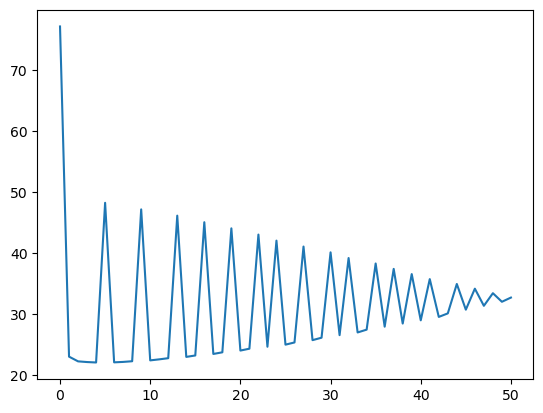

In [60]:
plt.plot(p_old4)
print(p_old4[0], p_old4[-1])

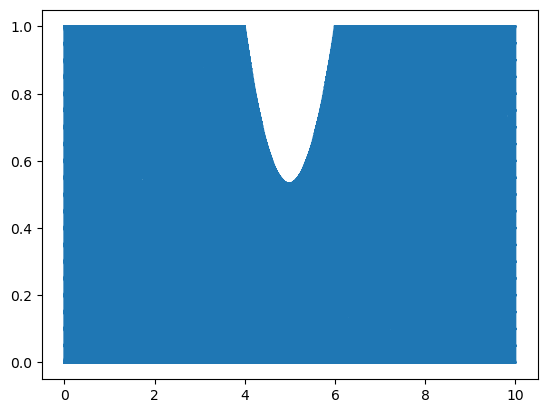

In [53]:
import matplotlib.pyplot as plt

# Get mesh data
nodes = gmsh.model.mesh.getNodes()
elements = gmsh.model.mesh.getElements()

# Extract 2D triangular elements
triangles = elements[2][1].reshape(-1, 3) - 1
x = nodes[1].reshape(-1, 3)[:, 0]
y = nodes[1].reshape(-1, 3)[:, 1]

# Plot the mesh
plt.figure()
plt.triplot(x, y, triangles)
#plt.ylim(-.1,1.1)
#plt.xlim(3,7)
#plt.axis('equal')
plt.show()

In [52]:
ones.size

100

In [6]:
L = 10
startpoint = L/2-L/10
endpoint = L/2+L/10
x = np.linspace(startpoint, endpoint, 100)

In [7]:
x

array([4.        , 4.02020202, 4.04040404, 4.06060606, 4.08080808,
       4.1010101 , 4.12121212, 4.14141414, 4.16161616, 4.18181818,
       4.2020202 , 4.22222222, 4.24242424, 4.26262626, 4.28282828,
       4.3030303 , 4.32323232, 4.34343434, 4.36363636, 4.38383838,
       4.4040404 , 4.42424242, 4.44444444, 4.46464646, 4.48484848,
       4.50505051, 4.52525253, 4.54545455, 4.56565657, 4.58585859,
       4.60606061, 4.62626263, 4.64646465, 4.66666667, 4.68686869,
       4.70707071, 4.72727273, 4.74747475, 4.76767677, 4.78787879,
       4.80808081, 4.82828283, 4.84848485, 4.86868687, 4.88888889,
       4.90909091, 4.92929293, 4.94949495, 4.96969697, 4.98989899,
       5.01010101, 5.03030303, 5.05050505, 5.07070707, 5.09090909,
       5.11111111, 5.13131313, 5.15151515, 5.17171717, 5.19191919,
       5.21212121, 5.23232323, 5.25252525, 5.27272727, 5.29292929,
       5.31313131, 5.33333333, 5.35353535, 5.37373737, 5.39393939,
       5.41414141, 5.43434343, 5.45454545, 5.47474747, 5.49494